In [1]:
import numpy as np
import scipy
import matplotlib.pylab as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
import time
import matplotlib.pyplot as pltT

# Ex1

In [2]:
def Francis(A, max_iter, tol):
    k = 1
    V = np.identity(len(A))

    mask = np.ones(A.shape, dtype=bool)
    np.fill_diagonal(mask, 0)
    
    err = abs(max(A[mask].min(), A[mask].max(), key=abs))
    
    while k < max_iter and err > tol:
        Q,R = scipy.linalg.qr(A)
        err = abs(max(A[mask].min(), A[mask].max(), key=abs))
        A = R.dot(Q)
        V = V.dot(Q)
        k += 1

    return A,V,Q,R

[[-58   0   0   0   0   0   0   0   0   0]
 [  0  43   0   0   0   0   0   0   0   0]
 [  0   0  37   0   0   0   0   0   0   0]
 [  0   0   0 -35   0   0   0   0   0   0]
 [  0   0   0   0 -27   0   0   0   0   0]
 [  0   0   0   0   0  24   0   0   0   0]
 [  0   0   0   0   0   0  21   0   0   0]
 [  0   0   0   0   0   0   0   8   0   0]
 [  0   0   0   0   0   0   0   0  -7   0]
 [  0   0   0   0   0   0   0   0   0   1]]


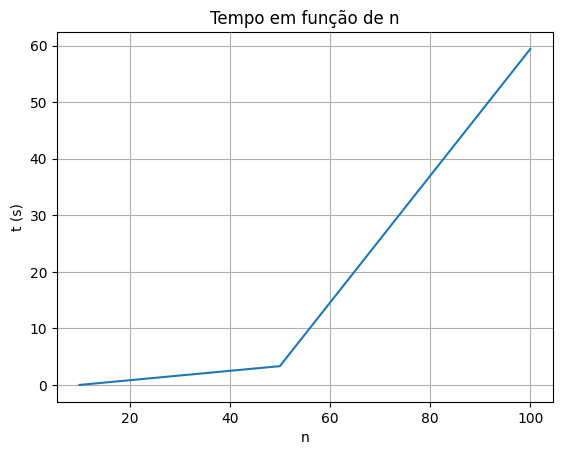

In [3]:
A = np.random.randint(-20,20,size=(10,10))
A = (A + A.T)/2
A,V,Q,R = Francis(A, 10**4, 10**-3)
print(A.astype(int))

tamanhos = []
tempos = []

for n in [10, 50, 100, 150, 200]:
    tamanhos.append(n)
    A = np.random.randint(-20,20,size=(n,n))
    A = (A + A.T)/2
    
    start = time.time()
    A,V,Q,R = Francis(A, 10**4, 10**-3)
    tempos.append(time.time() - start)
    
    #print(tempos)

pltT.plot(tamanhos, tempos)
pltT.grid()
pltT.xlabel('n')
pltT.ylabel('t (s)')
pltT.title('Tempo em função de n')
pltT.show()

# Ex2

In [4]:
def CriarMatriz(N, autovalores):
    #Autovalores na diagonal
    diag = np.diag(autovalores)

    #Matriz ortogonal necessária para criar uma matriz semelhante à diag
    aux = scipy.stats.ortho_group.rvs(N)

    #Matriz cheia semelhante à diag
    A = aux.dot(diag).dot(np.linalg.inv(aux))
    
    return A

N = 2
autovalores = []

for i in range(1, N**2, N):
    autovalores.append(i)

A = CriarMatriz(N, autovalores)

w, v = scipy.linalg.eigh(A)

print("Matriz:\n", A, "\n")
print("W = ", w,  "\nAutovalores = ", autovalores, "\n")
print("Autovetores:\n", v)

Matriz:
 [[1.78285577 0.97613953]
 [0.97613953 2.21714423]] 

W =  [1. 3.] 
Autovalores =  [1, 3] 

Autovetores:
 [[-0.78011032  0.62564198]
 [ 0.62564198  0.78011032]]


# Ex4

In [5]:
# Função para plotar os curvas de nível constante de temperatura
def PlotaMembrane(N1,N2,L1,L2,W):
    x = np.linspace(0, L1, N1)
    y = np.linspace(0, L2, N2)
    X,Y=np.meshgrid(x,y)
    Z = np.copy(W)
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set(xlabel='x', ylabel='y', title='Deslocamento vertical')
    im = ax.contourf(X, Y, Z, 20)
    im2 = ax.contour(X, Y, Z, 20, linewidths=0.25, colors='k')
    fig.colorbar(im, ax=ax)
    plt.show()
    
def PlotaSurface(N1,N2,L1,L2,W):
    x = np.linspace(0, L1, N1)
    y = np.linspace(0, L2, N2)
    X,Y=np.meshgrid(x,y)
    Z = np.copy(W)
    ax = plt.axes(projection ='3d')
    ax.plot_surface(X, Y, Z,cmap='viridis', edgecolor='none')
    ax.set(xlabel='x', ylabel='y', title='Deslocamento vertical')
    ax.set_zlim(-1.01, 1.01)
    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    

In [80]:
def ij2n (i, j, N):
    return i + j*N

def BuildMatrizesEigen(N1, N2, sigma, rho, e, delta):
    nunk = N1*N2

    # Stiffness matrix K: Build it as a sparse matrix 
    d1 = 4.0*np.ones(nunk)
    d2 = -np.ones(nunk-1)
    d3 = -np.ones(nunk-N1)
    K = (sigma/delta**2)*scipy.sparse.diags([d3, d2, d1, d2, d3], [-N1, -1, 0, 1, N1], format='csr')

    # Force the eigenvalues associated to boundary points 
    # to be a big number as compared to fundamental modes
    big_number = 10000
    Iden = big_number*scipy.sparse.identity(nunk, format='csr')

    # Lados verticais
    for k in range(0,N2):
        Ic = ij2n(0,k,N1) # Left
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]

        Ic = ij2n(N1-1,k,N1) # Right
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]
        
    # Lados horizontais
    for k in range(0,N1):
        Ic = ij2n(k,0,N1) # Bottom
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]

        Ic = ij2n(k,N2-1,N1) # Top
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]

    # Mass matrix: Simple case, multiple of identity
    M = rho*e*scipy.sparse.identity(nunk, format='csr')
    
    return K, M    

def BuildMembranaCircular(N, raio, sigma, rho, e, delta):
    nunk = N**2

    # Stiffness matrix K: Build it as a sparse matrix 
    d1 = 4.0*np.ones(nunk)
    d2 = -np.ones(nunk-1)
    d3 = -np.ones(nunk-N)
    K = (sigma/delta**2)*scipy.sparse.diags([d3, d2, d1, d2, d3], [-N, -1, 0, 1, N], format='csr')

    # Force the eigenvalues associated to boundary points 
    # to be a big number as compared to fundamental modes
    big_number = 10000
    Iden = big_number*scipy.sparse.identity(nunk, format='csr')

    meioX = (N-1)/2 * delta
    meioY = (N-1)/2 * delta
    
    for i in range(N):
        posX = i * delta
        for j in range(N):
            posY = j * delta

            if np.sqrt((posX - meioX)**2 + (posY - meioY)**2) > raio:
                Ic = ij2n(i,j,N)
                K[Ic,:] = Iden[Ic,:]

    # Mass matrix: Simple case, multiple of identity
    M = rho*e*scipy.sparse.identity(nunk, format='csr')
    
    return K, M    

def BuildMembranaVariavel(N1, N2, sigma, e, delta):
    nunk = N1*N2

    # Stiffness matrix K: Build it as a sparse matrix 
    d1 = 4.0*np.ones(nunk)
    d2 = -np.ones(nunk-1)
    d3 = -np.ones(nunk-N1)
    K = (sigma/delta**2)*scipy.sparse.diags([d3, d2, d1, d2, d3], [-N1, -1, 0, 1, N1], format='csr')

    # Force the eigenvalues associated to boundary points 
    # to be a big number as compared to fundamental modes
    big_number = 10000
    Iden = big_number*scipy.sparse.identity(nunk, format='csr')

    # Lados verticais
    for k in range(0,N2):
        Ic = ij2n(0,k,N1) # Left
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]

        Ic = ij2n(N1-1,k,N1) # Right
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]
        
    # Lados horizontais
    for k in range(0,N1):
        Ic = ij2n(k,0,N1) # Bottom
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]

        Ic = ij2n(k,N2-1,N1) # Top
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]

    # Mass matrix: Simple case, multiple of identity
    M = e*scipy.sparse.identity(nunk, format='csr')

    for i in range(N1):
        posX = i * delta
        for j in range(N2):
            posY = j * delta

            Ic = ij2n(i,j, N1)
            M[Ic,Ic] *= 1 + 0.75 * np.cos(4 * np.pi * posX) * np.cos(2 * np.pi * posY)

    return K, M    

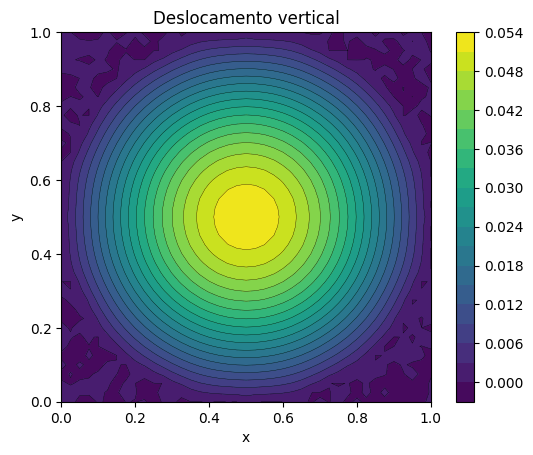

In [106]:
# Tamanho da grade
N = 41
L = 1
R = 0.5

# Distancia entre pontos: Cuidado que L1/(N1-1) seja igual a L2/(N2-1)
delta = L / (N-1) 

# Tensão da membrana
sigma = 1.0
rho = 1
e = 1

# Aplicar restrições nas bordas
K, M = BuildMembranaCircular(N, R, sigma, rho, e, delta)

# Método tipo potencias: Apenas os modos fundamentais (trabalha com esparsas!)
Lam, Q = scipy.sparse.linalg.eigsh(K, k=20, M=M, which='SM')

# Plotar Escolher um modo
k = 0
mode = Q[:,k]# + Q[:,1] + Q[:,2] + + Q[:,5] + Q[:,12]
Wplot = mode.reshape(N,N)
PlotaMembrane(N,N,L,L,Wplot)

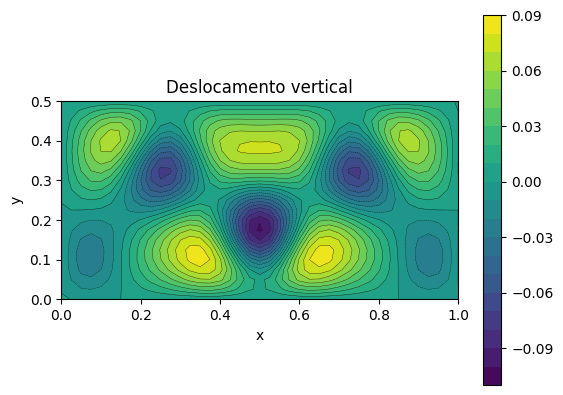

In [101]:
# Tamanho da grade
N1 = 41
N2 = 21
L1 = 1.0
L2 = 0.5
# Distancia entre pontos: Cuidado que L1/(N1-1) seja igual a L2/(N2-1)
delta = L1 / (N1-1) 

# Tensão da membrana
sigma = 1.0
e = 1

# Aplicar restrições nas bordas
K, M = BuildMembranaVariavel(N1, N2, sigma, e, delta)

# Método tipo potencias: Apenas os modos fundamentais (trabalha com esparsas!)
Lam, Q = scipy.sparse.linalg.eigsh(K, k=20, M=M, which='SM')

# Plotar Escolher um modo
k = 13
mode = Q[:,k]# + Q[:,1] + Q[:,2] + + Q[:,5] + Q[:,12]
Wplot = mode.reshape(N2,N1)
PlotaMembrane(N1,N2,L1,L2,Wplot)